# Predicting cancer: classifying malignant versus benign cells
## *Kimberly Sokal*
***


# Introduction

The accurate classification of cancerous cells is an extremely important, potentially life-altering process. Therefore, it is absolutely crucial to give it respect and critical consideration. Of the many potential use cases for developing a machine learning algorithm to perform a classification of malignant versus benign tumor cells, I focus on the perspective of the clinician and the patient. Getting a lab result with a probability that you have cancer can be extremely emotional, and my goal is to ease the emotional burden by making the diagnosis understandable.

These are the 3 factors that I consider to be the most important in an approach to this classification problem:
- accuracy
- false positives are preferable to false negatives
- understandability   

# Take away

In order to optimize interpretability and use, I  develop a decision tree model to identify cancerous cells. My final model has a 93% accuracy score and minimizes false negatives. With this high accuracy, the majority of the decisions throughout the tree can reliably classify benign versus malignant cells. It is easy to identify the few locations where data might get mislabeled, and therefore provides a clear guide where additional information is needed to make a more accurate prediction.

My final model is immediately applicable, even without the ability to run the model to get predictions. The medical office needs only to compare an individuals lab measurements to my final decision tree:

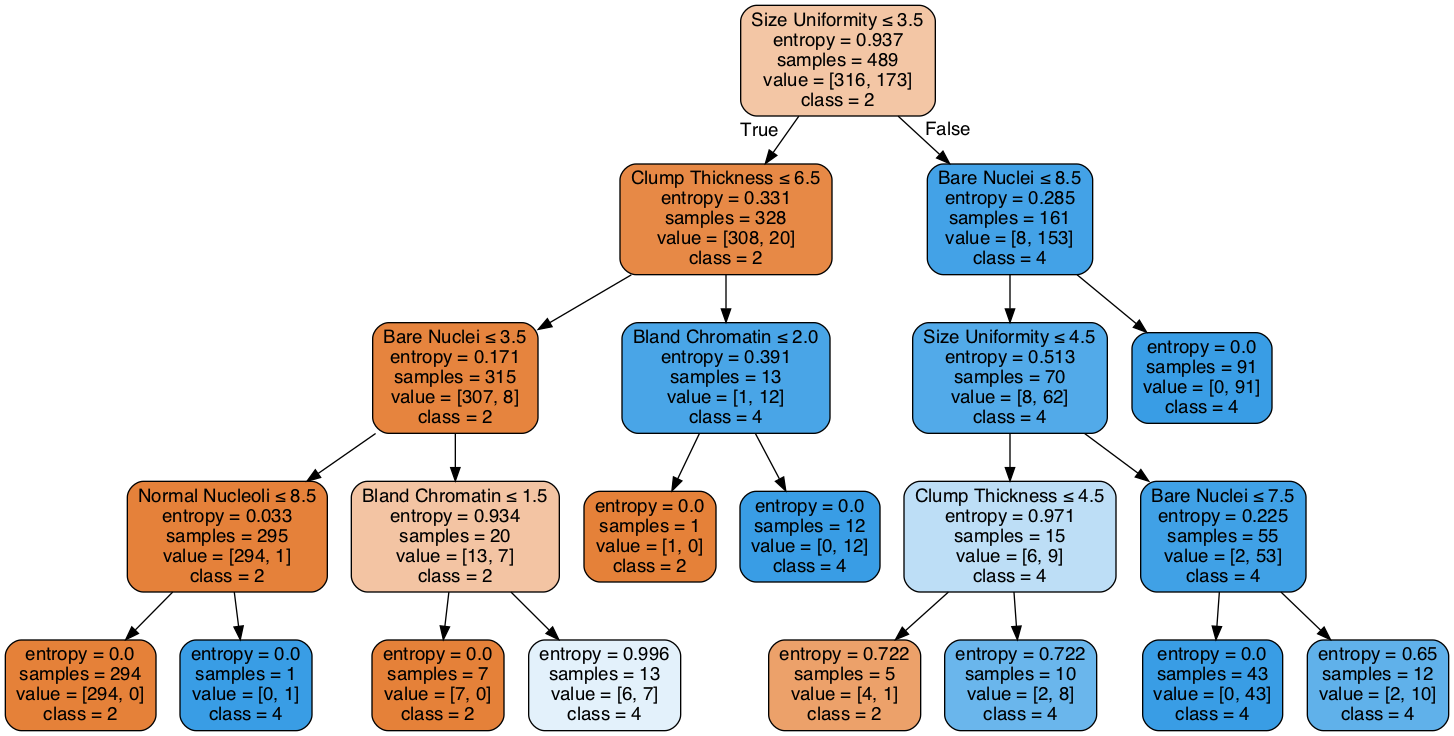

***

# Step 1: Data

### Before we begin, import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Read in the data

In [2]:
labdata=pd.read_csv("data.csv", header=None, names=["ID","Clump Thickness","Size Uniformity","Shape Uniformity",
                                           "Marginal Adhesion","Single Epithelial Size","Bare Nuclei",
                                                    "Bland Chromatin","Normal Nucleoli","Mitoses","class"])


A few notes about this data.

source: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Original)

summary: The data is composed of medical measurements of biopsied breast cells. Most importantly, "class" refers to the classification of the cell as either benign (class = 2) or malignant (class=4). The rest of the columns labels are medical measurements for different attributes of the cell.

### Clean and preprocess the data

In [3]:
labdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
ID                        699 non-null int64
Clump Thickness           699 non-null int64
Size Uniformity           699 non-null int64
Shape Uniformity          699 non-null int64
Marginal Adhesion         699 non-null int64
Single Epithelial Size    699 non-null int64
Bare Nuclei               699 non-null object
Bland Chromatin           699 non-null int64
Normal Nucleoli           699 non-null int64
Mitoses                   699 non-null int64
class                     699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


We see that the 'Normal Nuclei' column contains entries that are not integers. 
Identify the problem and then then fix it such that the column is of the same type as the rest of the table.

In [4]:
labdata["Bare Nuclei"].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

In [5]:
labdata["Bare Nuclei"].replace("?",None, inplace=True)
labdata["Bare Nuclei"]=labdata["Bare Nuclei"].astype(int)
labdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
ID                        699 non-null int64
Clump Thickness           699 non-null int64
Size Uniformity           699 non-null int64
Shape Uniformity          699 non-null int64
Marginal Adhesion         699 non-null int64
Single Epithelial Size    699 non-null int64
Bare Nuclei               699 non-null int64
Bland Chromatin           699 non-null int64
Normal Nucleoli           699 non-null int64
Mitoses                   699 non-null int64
class                     699 non-null int64
dtypes: int64(11)
memory usage: 60.1 KB


Check the table format and content

In [6]:
labdata.tail()

,ID,Clump Thickness,Size Uniformity,Shape Uniformity,Marginal Adhesion,Single Epithelial Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,class
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4
698,897471,4,8,8,5,4,5,10,4,1,4


### Data exploration

First, quickly visualize the relationships between the attributes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11aab3a20>,
      dtype=object)

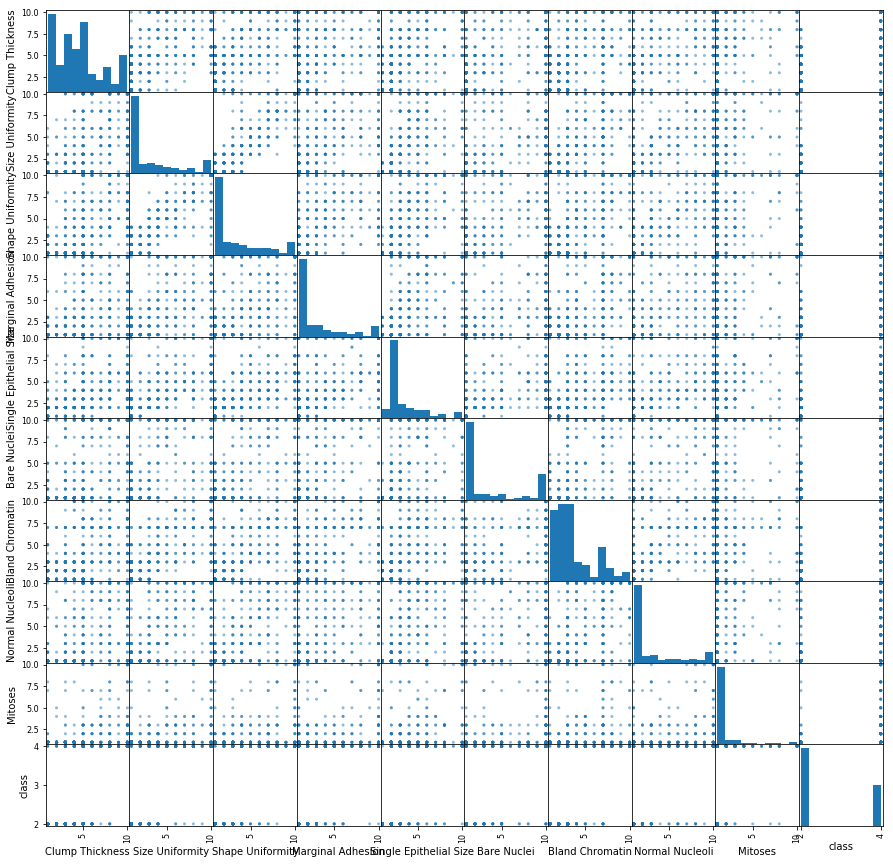

In [7]:
pd.plotting.scatter_matrix(labdata.drop(columns="ID"),figsize=(15,15), diagonal='hist')
#Drop the ID because that plot will not provide useful trends

*Figure 1- A composite figure showing a scatter plot of all attributes plotted against all other attributes. The diagonal, which corresponds the the same attribute against itself, instead shows a histogram for that attribute.*

Any obvious trends? It is quite apparent that size uniformity and shape uniformity are correlated.

Next, how are the different attributes related to the resulting class?

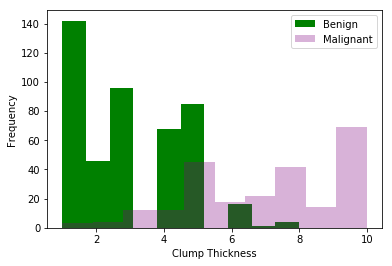

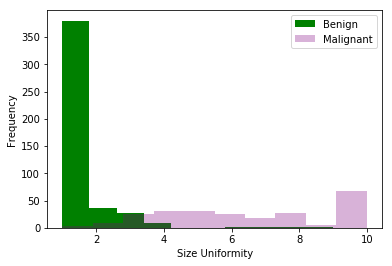

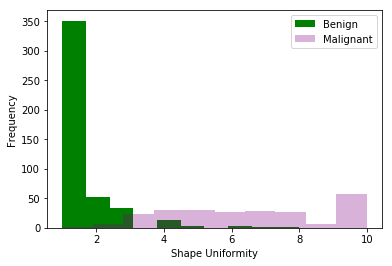

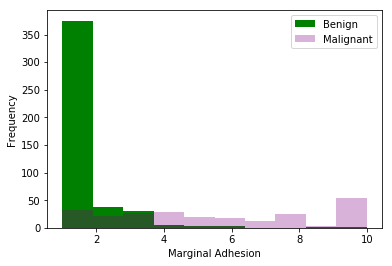

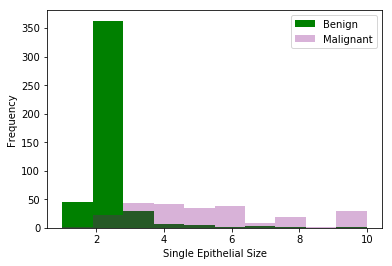

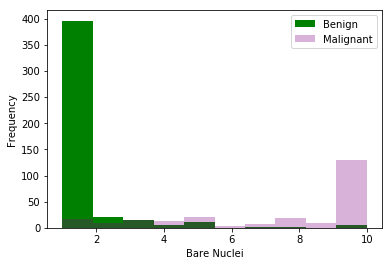

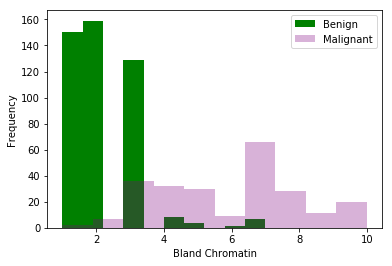

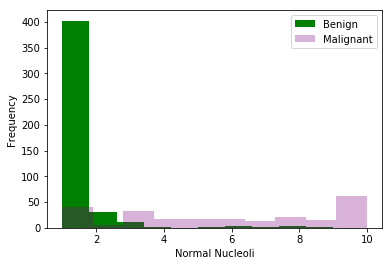

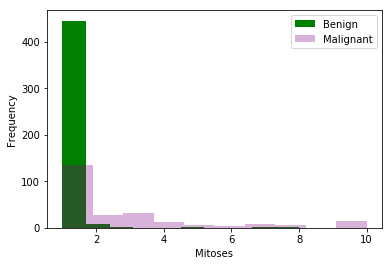

In [8]:
#The following function will plot make a plot for each attribute

#as with above, do not include ID and in this case, the class will be represented otherwise.
for columnname in labdata.drop(columns=["ID","class"]).columns.values:
    labdata[columnname][labdata['class'] ==2].plot.hist(color="green", label = "Benign")
    labdata[columnname][labdata['class'] ==4].plot.hist(color="purple", alpha=0.3, label="Malignant")
    plt.xlabel(columnname)
    plt.legend(loc="upper right")
    plt.show()


*Figure 2 - Histograms for all attributes that are color coded by their  classification as benign or malignant.*

It is immediately clear that benign is the most common, but there are several indicators where the only large values correspond to malignant. Therefore, this confirms that these features should adequately be able to predict cancerous cells.

# Step 2. Developing a model

### before we begin, import packages

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib.legend_handler import HandlerLine2D

### First a basic application of a decision tree

As mentioned in the intro, I opt for the interpretability of a decision tree.
I found that more sophisticated implementations, such as a gradient boosted tree, produce very similar results. The trade off for a minor improvement in accuracy is an explaination given as a black box model predictor, which I find a compelling reason to stick with a simple approach.

In [10]:
#Separate the data into the attributes as the features and the class as the label
feature_names=['Clump Thickness', 'Size Uniformity', 'Shape Uniformity',
       'Marginal Adhesion', 'Single Epithelial Size', 'Bare Nuclei',
       'Bland Chromatin', 'Normal Nucleoli', 'Mitoses']
X=labdata[feature_names] #feature data 
y=labdata["class"] #label

#Split the data into a 70% training and 30% test set (randomly drawing from the full sample)
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3, random_state=2)

Create a decision tree classifier and train it

In [11]:
simple_tree=DecisionTreeClassifier()
simple_tree=simple_tree.fit(X_train,y_train)

Investigate the results.

In [12]:
#predict the response for the train dataset
train_pred=simple_tree.predict(X_train)
#predict the response for the test dataset
y_pred=simple_tree.predict(X_test)

#compute the model accuracy
accuracy=metrics.accuracy_score(y_test,y_pred)
print('Accuracy score: ',accuracy)

#compute the area under the curve: Train
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred,pos_label=4)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
print('Train AUC: ', roc_auc)
   
#compute the area under the curve: Test
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=4)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
print('Test AUC: ', roc_auc)

#compute a confusion matrix
cm=metrics.confusion_matrix(y_test,y_pred)
print('Test Confusion matrix: ')
print(cm)

Accuracy score:  0.9238095238095239
Train AUC:  1.0
Test AUC:  0.9130074565037282
Test Confusion matrix: 
[[134   8]
 [  8  60]]


### Tune the classifier

One feature that is extremely important in the development of the tree classifier for this dataset is the
depth. I also investigated methods of pruning the tree, but found that the resulting trees were less informative to the user and not worth pursuing. Additionally, the 'entropy' criterion produced more understandable splits.

Identifying the optimal depth (number of levels)

In [13]:
#set up the range we will test, from 1 to 25 levels
max_depths = np.linspace(1, 25, 25, endpoint=True)
train_results = []
test_results = []

#step through each depth, following similar code from above.
#store the AUC ROC results for each step.
for max_depth in max_depths:
    #define a tree classifier and fit it
    dt = DecisionTreeClassifier(max_depth=max_depth,criterion="entropy")
    dt.fit(X_train, y_train)
    
    #find the predictions for the training set
    train_pred = dt.predict(X_train)    
    #compute the area under the curve
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred,pos_label=4)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)

    #find the predictions for the training set
    y_pred = dt.predict(X_test)
    #compute the area under the curve
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred,pos_label=4)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

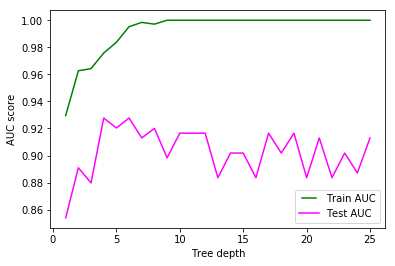

In [14]:
#plot the results
line1, = plt.plot(max_depths, train_results, color='green', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'magenta', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

*Figure 3 - A figure showing the decision tree model's sensitivity to the depth of the tree, as indicated by the Area under the curve (AUC) score. *

We see a peak at ~4, and therefore will set our tree classifier to that depth.

Lets run the resulting model after implementing these decisions.

In [15]:
#define the tree classifier and fit it
tuned_tree=DecisionTreeClassifier(max_depth=4,criterion="entropy")
tuned_tree=tuned_tree.fit(X_train,y_train)

#predict the response for the train dataset
train_pred=tuned_tree.predict(X_train)
#predict the response for the test dataset
y_pred=tuned_tree.predict(X_test)

#compute the model accuracy
accuracy=metrics.accuracy_score(y_test,y_pred)
print('Accuracy score: ',accuracy)

#compute the area under the curve: Train
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred,pos_label=4)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
print('Train AUC: ', roc_auc)
   
#compute the area under the curve: Test
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=4)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
print('Test AUC: ', roc_auc)

#compute a confusion matrix
cm=metrics.confusion_matrix(y_test,y_pred)
print('Test Confusion matrix: ')
print(cm)

Accuracy score:  0.9333333333333333
Train AUC:  0.9757810785102803
Test AUC:  0.9277133388566693
Test Confusion matrix: 
[[134   8]
 [  6  62]]


### Feature engineering

Now that we have the number of levels set, it is worthwhile to investigate the attributes input as features. 

In [16]:
#Lets test the feature important of our tuned tree model
tuned_tree.feature_importances_

array([0.11636032, 0.73084492, 0.0113446 , 0.        , 0.        ,
       0.09362073, 0.02529138, 0.02253804, 0.        ])

Three of the attributes are being given a feature importance of 0, and one more that is quite small. Therefore, this suggests that their addition as input into our model is not adding value, and could potentially add noise. 

In [17]:
#Remove the features with low importance
feature_names_eng=['Clump Thickness', 'Size Uniformity','Bare Nuclei',
       'Bland Chromatin', 'Normal Nucleoli']
X=labdata[feature_names_eng] #feature data 
y=labdata["class"] #label

#Split the data into a 70% training and 30% test set (randomly drawing from the full sample)
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3, random_state=2)

Apply our newly feature-engineered model

In [18]:
#define the tree classifier and fit it
final_tree=DecisionTreeClassifier(max_depth=4,criterion="entropy")
final_tree=final_tree.fit(X_train,y_train)

#predict the response for the train dataset
train_pred=final_tree.predict(X_train)
#predict the response for the test dataset
y_pred=final_tree.predict(X_test)

#compute the model accuracy
accuracy=metrics.accuracy_score(y_test,y_pred)
print('Accuracy score: ',accuracy)

#compute the area under the curve: Train
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, train_pred,pos_label=4)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
print('Train AUC: ', roc_auc)
   
#compute the area under the curve: Test
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=4)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
print('Test AUC: ', roc_auc)

#compute a confusion matrix
cm=metrics.confusion_matrix(y_test,y_pred)
print('Test Confusion matrix: ')
print(cm)

Accuracy score:  0.9333333333333333
Train AUC:  0.9812870417794689
Test AUC:  0.9315451532725766
Test Confusion matrix: 
[[133   9]
 [  5  63]]


# Step 3. User case: Evaluation of selecting the final model

In above steps, I present the selection of a final model based on typical diagnostics, including accuracy scores and confusion matrices to show the performance improvements at each step. 

Before you should consider this model the final, I would also like to demonstrate the improvements in the model in its domain - actually the interpretability and usage of the attribute information.

### before we begin, import packages

In [19]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

### Basic tree

Lets see where we started from:
- simple tree before any improvements to model were made
- accuracy score of 0.9238

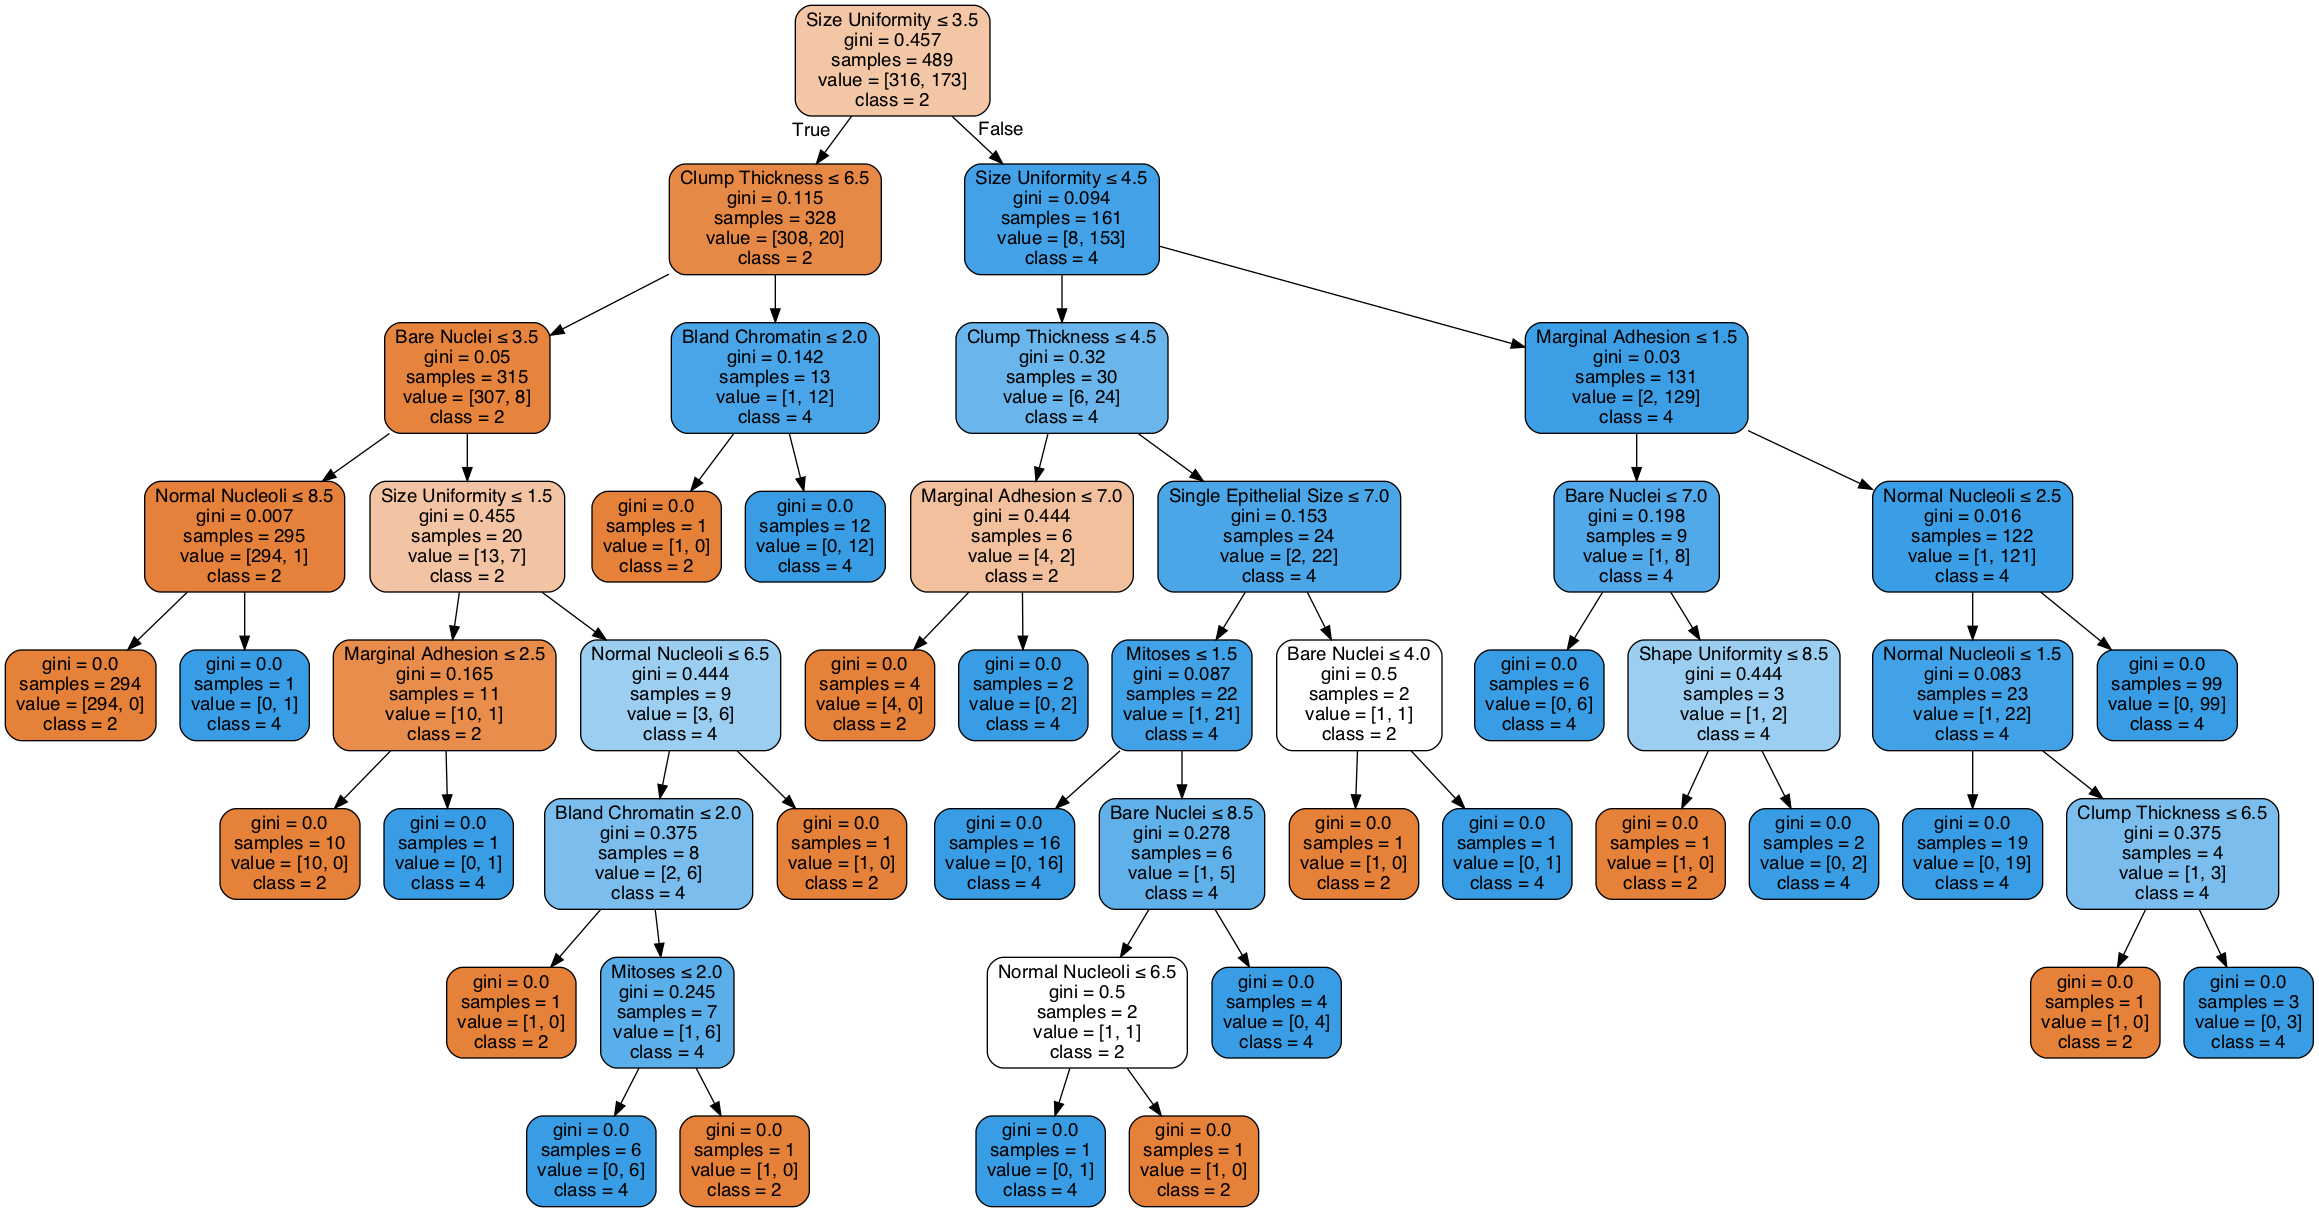

In [20]:
#show the tree
dot_data = StringIO()
export_graphviz(simple_tree,out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_names,class_names=['2','4'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('simple_tree_plot.png')
Image(graph.create_png())

*Figure 4 - A simple, non-optimized decision tree model for the lab data.*

### Tuned tree

The tuned tree is an improvement on the very complicated, deep tree shown above, primarily:
- the maximum depth is optimized to 4
- the accuracy is 0.9333 (higher than the original tree)


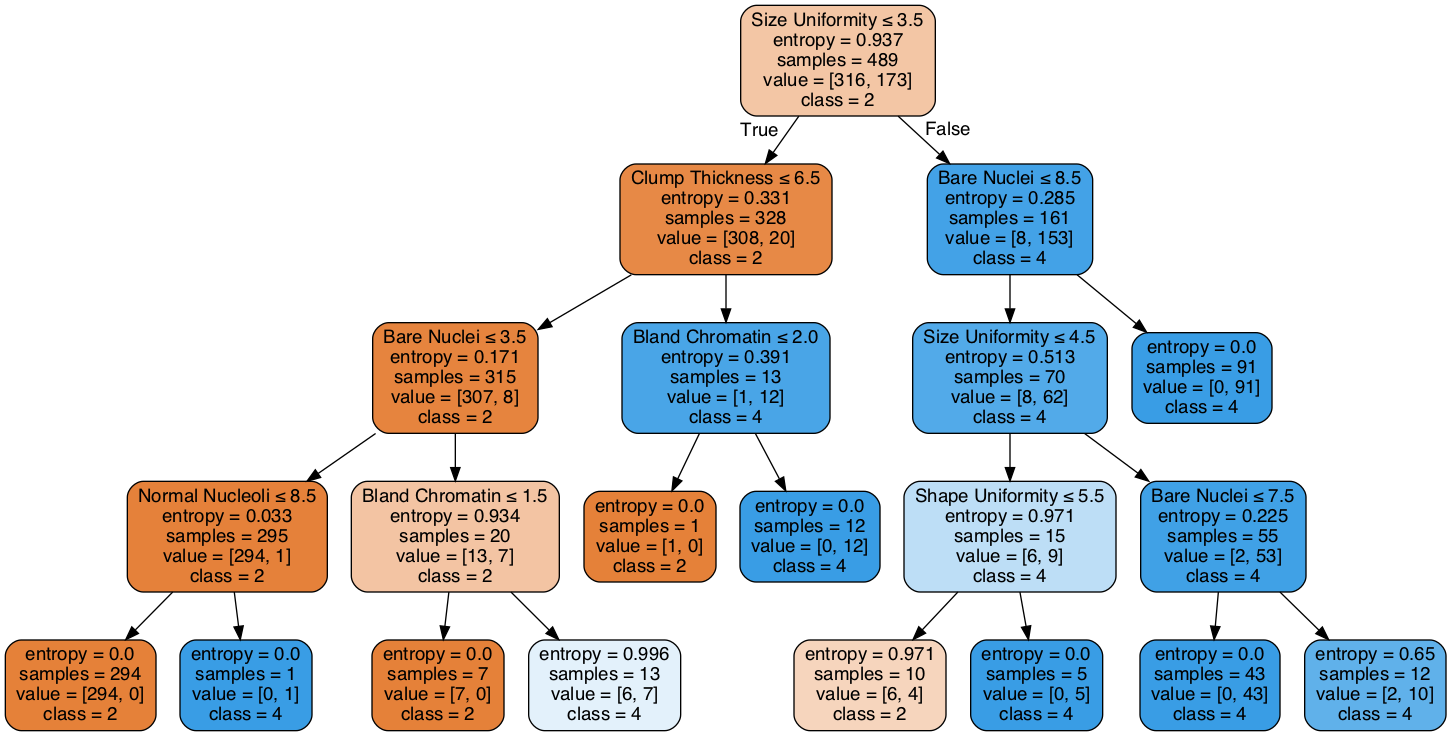

In [21]:
#show the tree
dot_data = StringIO()
export_graphviz(tuned_tree,out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_names,class_names=['2','4'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('tuned_tree_plot.png')
Image(graph.create_png())

*Figure 5 - An improved decision tree, refered to as the "tuned tree" version in which the depth and method of comparison were optimized.*

### Final Tree

The next and final modification made to the model was feature engineering:
- removed four of the attributes that provide zero to little information content
- accuracy is 0.9333

This last step produced the same accuracy score, so is it worth cutting potentially valuable data? 
The resulting changes to the nodes in the decision tree point to a yes.

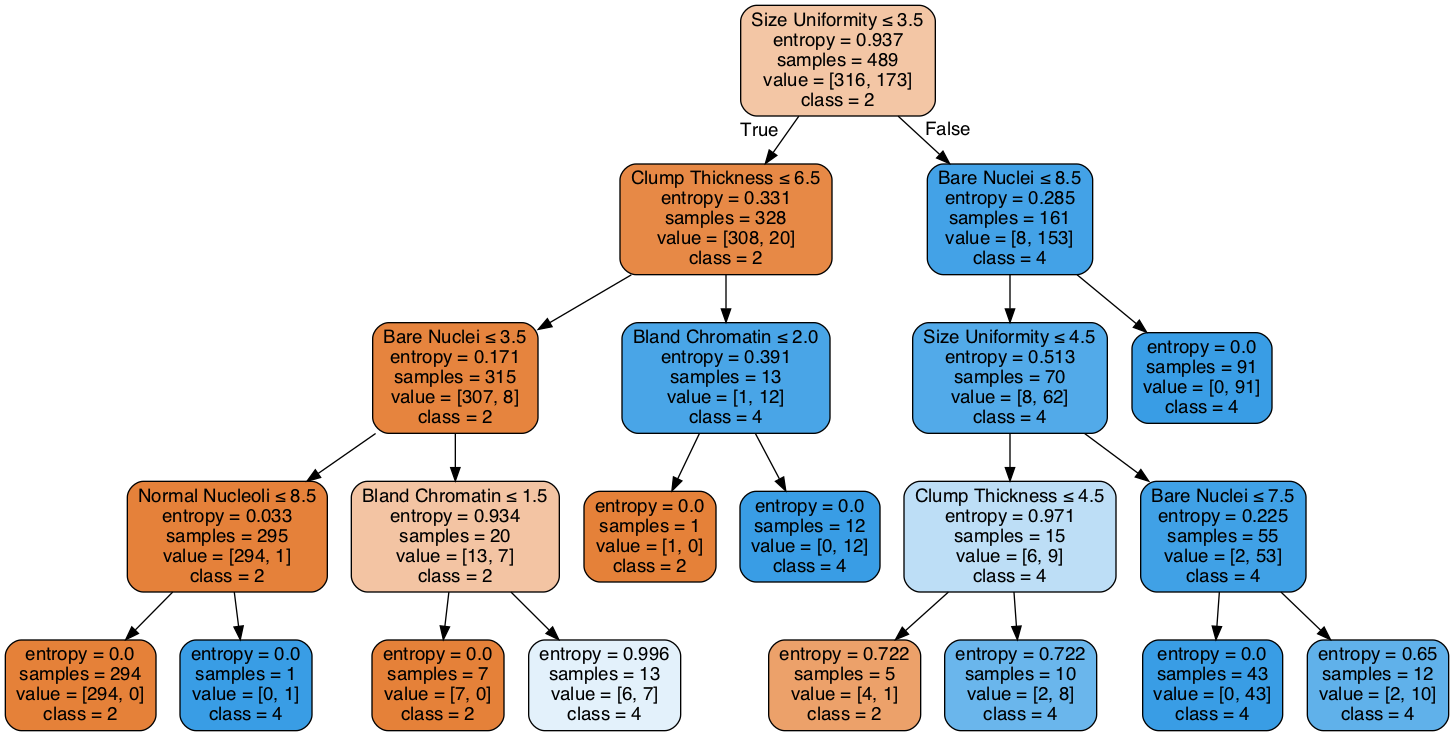

In [22]:
#show the tree
dot_data = StringIO()
export_graphviz(final_tree,out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_names_eng,class_names=['2','4'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('final_tree_plot.png')
Image(graph.create_png())

*Figure 6 - The final decision tree depicting a clear and informative path in the prediction of the final class.*

The final tree is very similar to the one before, with the change resulting on one node specifically.
This leads to the leafs on the bottom row (7 & 8 from the left, 3& 4 from the right). This node changed from the shape uniformity attribute to the clump thickness.

The minor modification is preferable:
- our data exploration indicated that the shape uniformity is correlated with size uniformity. Therefore my feature engineering led to a swap of a fairly duplicate attribute with one that was important in the other branches of the tree, clump thickness. 
- numerically, the number of false negatives (falsely classified as 2/benign) decreased on the test dataset overall from 6 to 5. The decision tree diagrams on the training data also show that the number of false negatives decreased in the training data from 4 to 1 specifically in the leaf resulting from the updated node. 

In summary: this change resulted in less false negatives and better utilizes the information gain from attributes.
 

Final note, not only can this code be easily implemented and repeated for future datasets, it is immediately applicable as is in the medical office.
The decision tree can simply be viewed or printed out and an individuals measurements can be followed through. 
There are many cases where the results are definitive, and in the few nodes where their is some level of potential confusion, then next level strategies can be taken (more precise black box models or additional lab tests or more frequent doctor follow up).